# Necessary libraries

In [1]:
!pip install nltk
!python -m spacy download en_core_web_sm -q

2023-07-10 22:14:16.230337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 22:14:20.745455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd

# Download spacy for the english language
import en_core_web_sm
nlp = en_core_web_sm.load()
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from gensim import models, corpora
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [3]:
df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",encoding='ISO-8859-1"')

In [4]:
df.head()
# We see 3 columns with a lot of missing values

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.describe()
# We could remove the 3 columns

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [6]:
# Create one dataframe with columns 2,3,4 removed
df_columns01 = df.iloc[:,:2]
df_columns01.columns = ['target','text']
print(df_columns01.head())

# Create one dataframe with columns 1,2,3,4 merged
df_columns01234 = df
df_columns01234['v2'] = df_columns01234['v2'] + " " + df_columns01234['Unnamed: 2'].fillna('') + " " + df_columns01234['Unnamed: 3'].fillna('') + " " + df_columns01234['Unnamed: 4'].fillna('')
other_columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4']
df_columns01234 = df_columns01234.drop(columns = other_columns)
df_columns01234.columns = ['target','text']
print(df_columns01234.head())

# Create a dictionnary containing the 2 dataframes
df_list={"df_columns01":df_columns01, "df_columns01234":df_columns01234}


  target                                               text
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...
  target                                               text
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                   Ok lar... Joking wif u oni...   
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...


In [7]:
# Preprocess each dataframe with or without keeping the special characters (they could be a sign of SPAM so we might better keep them)

# Create a list for the 4 dataframes (the 2 previous dataframes preprocessed with or without removal of special characters)
df_preprocessed_list = {}

for df_name, df in df_list.items():
  new_dataset_name = f"{df_name}_preprocessing_without_special_cha"
  df_preprocessed_list[new_dataset_name] = df.copy()
  df_preprocessed_list[new_dataset_name]["cleaned_text"] = df_preprocessed_list[new_dataset_name]["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
  df_preprocessed_list[new_dataset_name]["cleaned_text"] = df_preprocessed_list[new_dataset_name]["cleaned_text"].apply(lambda x: x.replace(" +"," ").lower().strip())
  df_preprocessed_list[new_dataset_name]["cleaned_text"] = df_preprocessed_list[new_dataset_name]["cleaned_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
  df_preprocessed_list[new_dataset_name]["target"] = df_preprocessed_list[new_dataset_name]["target"].apply(lambda x: 0 if x == "ham" else 1)

for df_name, df in df_list.items():
  new_dataset_name = f"{df_name}_preprocessing_with_special_cha"
  df_preprocessed_list[new_dataset_name] = df.copy()
  df_preprocessed_list[new_dataset_name]["cleaned_text"] = df_preprocessed_list[new_dataset_name]["text"].apply(lambda x: x.replace(" +"," ").lower().strip())
  df_preprocessed_list[new_dataset_name]["cleaned_text"] = df_preprocessed_list[new_dataset_name]["cleaned_text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
  df_preprocessed_list[new_dataset_name]["target"] = df_preprocessed_list[new_dataset_name]["target"].apply(lambda x: 0 if x == "ham" else 1)


In [8]:
# Tokenization for each dataframe

tokenizer_dict = {}

for df_name, df in df_preprocessed_list.items():
    # Create a new tokenizer for each df
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="out_of_vocab")
    tokenizer.fit_on_texts(df["cleaned_text"])
    df["encoded_text"] = tokenizer.texts_to_sequences(df["cleaned_text"])
    # Save the specific fitted tokenizer of each df
    tokenizer_dict[df_name] = tokenizer

# Preprocessing EDA

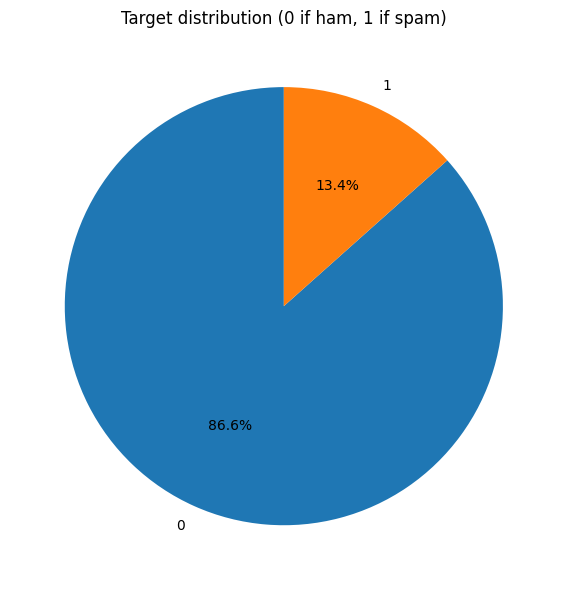

The dataset is quite imbalanced


In [9]:
# Spam distribution

# Selection of the 1st dataframe
df_name, df = next(iter(df_preprocessed_list.items()))
# Class distribution
class_counts = df["target"].value_counts() # count spams and hams
labels = class_counts.index.tolist() # creates a list of labels (0 and 1)
sizes = class_counts.values.tolist() # creates a list of the 0 and 1 counts
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Target distribution (0 if ham, 1 if spam)")
# Display the plot
plt.tight_layout()
plt.show()
print("The dataset is quite imbalanced")

In [10]:
# Vocabulary size

vocabulary_data = {}
for df_name, df in df_preprocessed_list.items():
    vocab_size = len(tokenizer_dict[df_name].word_index)
    vocabulary_data[df_name] = {'Vocabulary Size': vocab_size}
vocabulary_df = pd.DataFrame.from_dict(vocabulary_data, orient='index')
print(vocabulary_df)

print("Removal of special characters increase vocabulary size.")
print("Explanation in examples: blabla@gmail.com is transformed in 2 words. doesn't and doesnt would be 2 differnet words.")

                                                   Vocabulary Size
df_columns01234_preprocessing_with_special_cha                7690
df_columns01234_preprocessing_without_special_cha             8285
df_columns01_preprocessing_with_special_cha                   7603
df_columns01_preprocessing_without_special_cha                8189
Removal of special characters increase vocabulary size.
Explanation in examples: blabla@gmail.com is transformed in 2 words. doesn't and doesnt would be 2 differnet words.


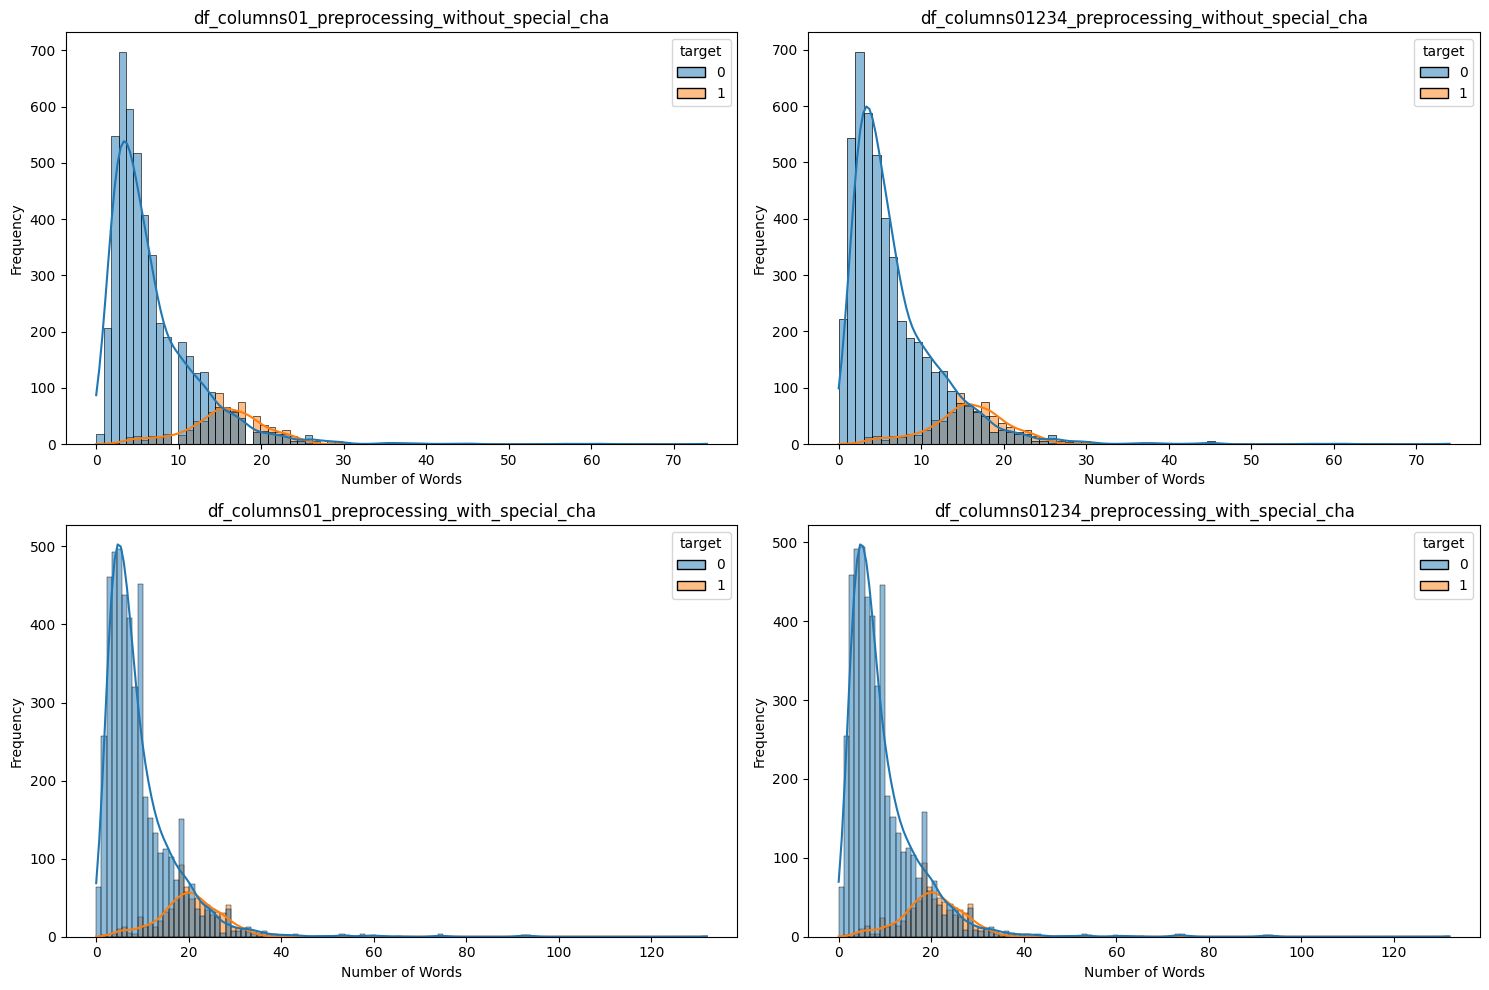

In all cases, it seems that spams contain much longer messages than hams. It seems more clear when removing special characters.


In [12]:
# Word Frequency Analysis

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, (df_name, df) in enumerate(df_preprocessed_list.items()):
    # Calculate word count for each text
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

    ax = axes[i//2, i%2]
    sns.histplot(data=df, x="word_count", hue="target", kde=True, ax=ax) # hue is color differenciation ; kde = kernel density estimation (estimation of the underlying probability density function of the data)
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Frequency")
    ax.set_title(df_name)

plt.tight_layout()
plt.show()

print("In all cases, it seems that spams contain much longer messages than hams. It seems more clear when removing special characters.")

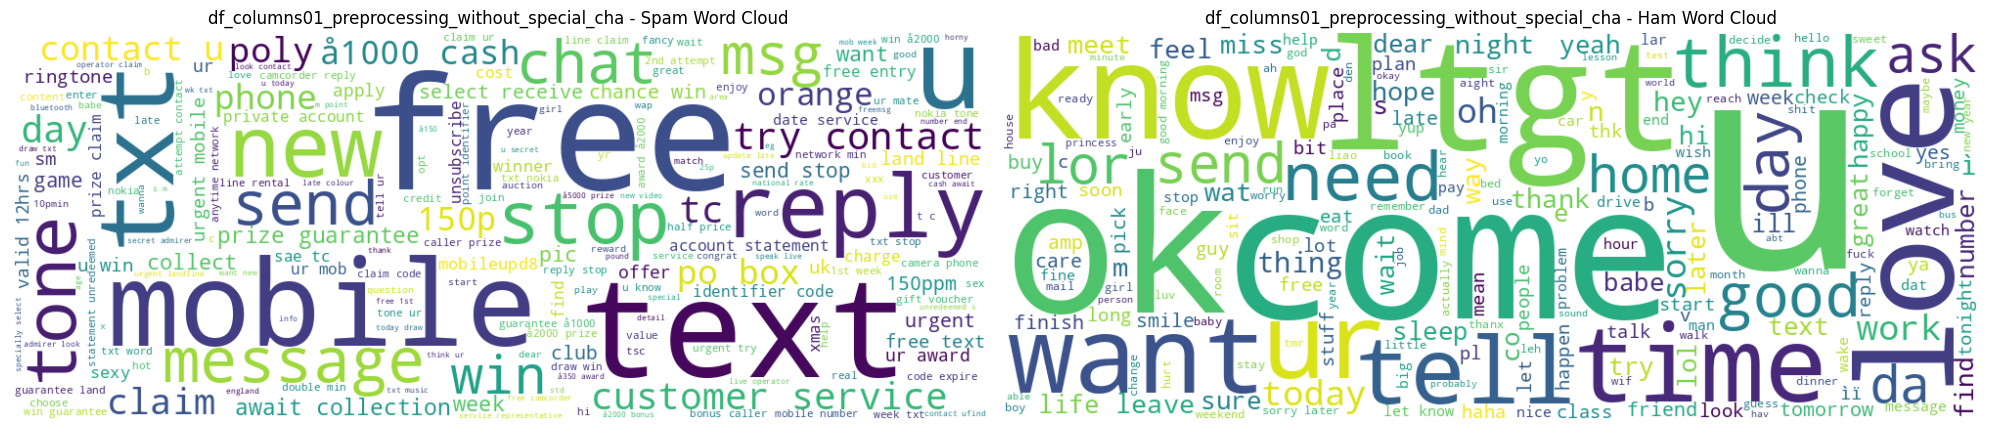

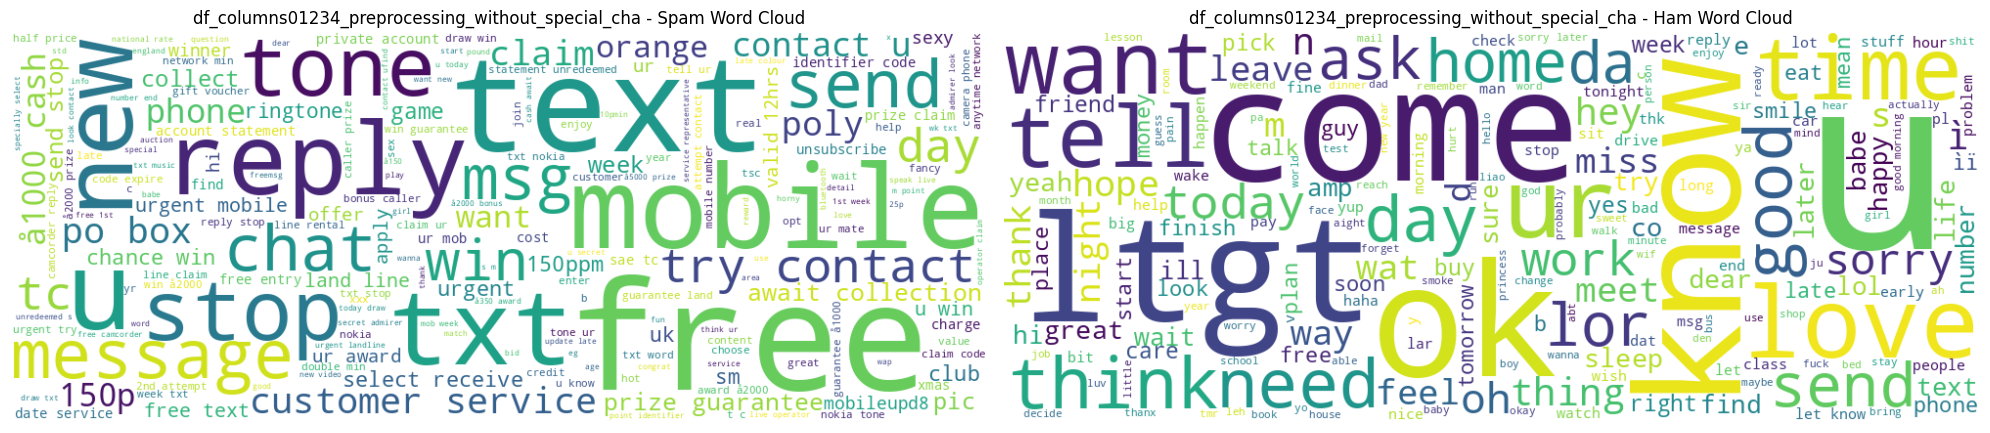

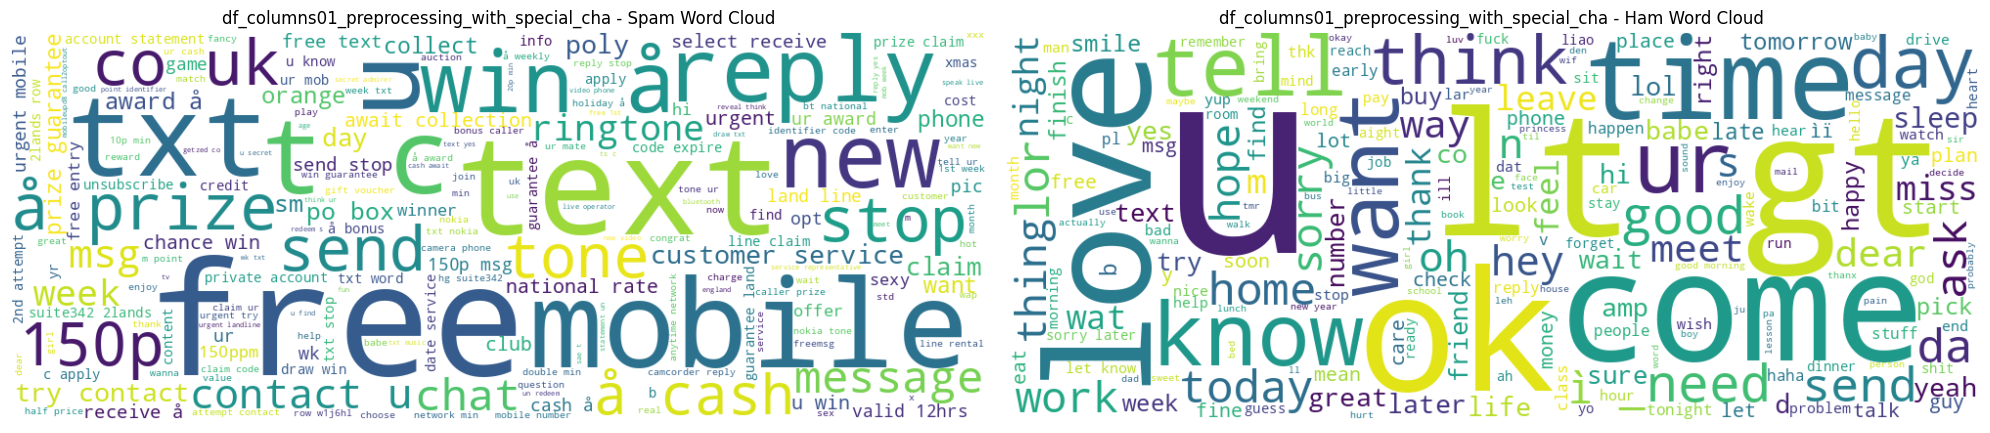

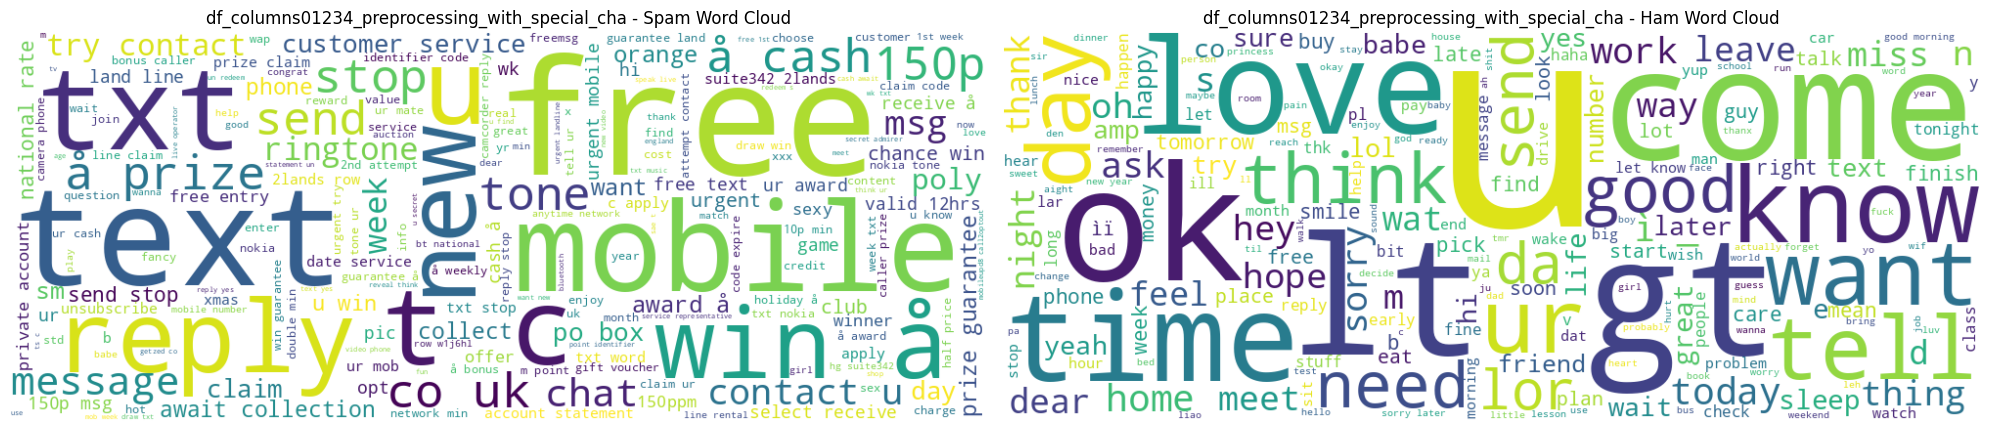

We see here that spams contains a lot the words: free, text, mobile, reply, cash, sexy etc. which are words related to advertisment.
In the opposite, the hams contain random words about everything.


In [13]:
# Word clouds

for df_name, df in df_preprocessed_list.items():
    # Separate by spam and ham
    spam_data = df[df['target'] == 1]['cleaned_text']
    ham_data = df[df['target'] == 0]['cleaned_text']

    # Word Cloud for spam data / ham data
    spam_text = ' '.join(spam_data)
    spam_wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(spam_text)
    ham_text = ' '.join(ham_data)
    ham_wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(ham_text)

    # Plot Word Clouds
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(spam_wordcloud, interpolation='bilinear')
    axes[0].set_title(f"{df_name} - Spam Word Cloud")
    axes[0].axis('off')
    axes[1].imshow(ham_wordcloud, interpolation='bilinear')
    axes[1].set_title(f"{df_name} - Ham Word Cloud")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

print("We see here that spams contains a lot the words: free, text, mobile, reply, cash, sexy etc. which are words related to advertisment.")
print("In the opposite, the hams contain random words about everything.")

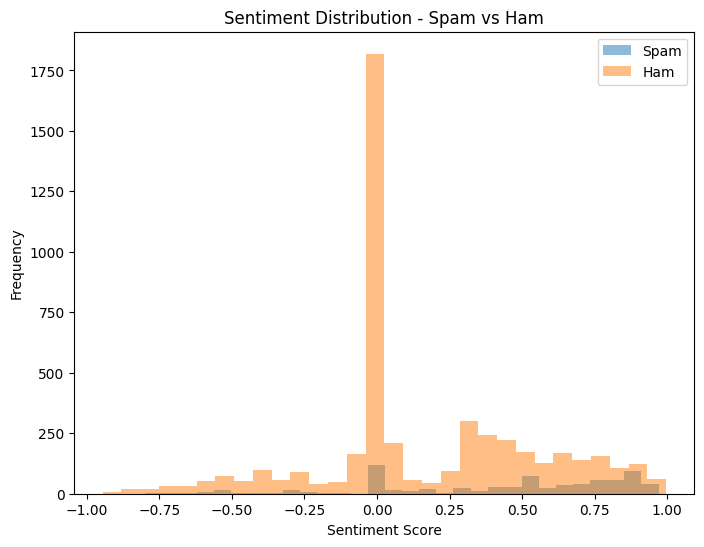

For non spam emails, most of the texts have no feeling at all (super high frequency at zero).
On the opposite, spams contain a lot a positive sentiments, more than the zero feeling.


In [14]:
# Sentiment Analysis (example using Vader sentiment analyzer from NLTK)

# This is used to check the general tone/feeling of a text. Maybe we see differences between spams and hams.

# Let's check only one graph
df_name, df = next(iter(df_preprocessed_list.items()))
sid = SentimentIntensityAnalyzer()

# Separate spams/hams
df_spam = df[df["target"] == 1]
df_ham = df[df["target"] == 0]

# Sentiment analysis
sentiment_scores_spam = df_spam["cleaned_text"].apply(lambda x: sid.polarity_scores(x)["compound"])
sentiment_scores_ham = df_ham["cleaned_text"].apply(lambda x: sid.polarity_scores(x)["compound"])

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(sentiment_scores_spam, bins=30, alpha=0.5, label="Spam")
plt.hist(sentiment_scores_ham, bins=30, alpha=0.5, label="Ham")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution - Spam vs Ham")
plt.legend()
plt.show()

print("For non spam emails, most of the texts have no feeling at all (super high frequency at zero).")
print("On the opposite, spams contain a lot a positive sentiments, more than the zero feeling.")

# Model

In [15]:
# Create lists to store useful analysis data
loss_values = []
val_loss_values = []
accuracy_values = []
val_accuracy_values = []
confusion_matrix_lists = []

# Loop for each dataframe
for df_name, df in df_preprocessed_list.items():

    # Padding (same size everywhere), usually realized after EDA
    text_pad = tf.keras.preprocessing.sequence.pad_sequences(df["encoded_text"], padding="post")

    # Train Test Split + make batches
    xtrain, xval, ytrain, yval = train_test_split(text_pad, df["target"], test_size=0.3, stratify=df["target"]) # do not forget stratify as x/y is imbalanced
    train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
    val = tf.data.Dataset.from_tensor_slices((xval, yval))
    train_batch = train.shuffle(len(train)).batch(64)
    val_batch = val.shuffle(len(val)).batch(64)

    # Defining the model
    # Vocab_size is different for each dataframe so we need to do the model inside the loop
    vocab_size = tokenizer_dict[df_name].num_words
    embedding_dim = 16 # we can check different ones later
    model = tf.keras.Sequential([
        # Input Word Embedding layer
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_shape=[text_pad.shape[1],],name="embedding"),
        # Gobal average pooling
        tf.keras.layers.GlobalAveragePooling1D(),
        # Layer Dense classique
        tf.keras.layers.Dense(16, activation='relu'),
        # Binary classification ==> 1 neuron with activation sigmoid
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile the model with legacy optimizer, then fit
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    history = model.fit(train_batch, epochs=30, validation_data=val_batch)

    # Save loss and accuracy into lists
    loss_values.append(history.history["loss"])
    val_loss_values.append(history.history["val_loss"])
    accuracy_values.append(history.history["accuracy"])
    val_accuracy_values.append(history.history["val_accuracy"])

    # Get the model's predictions
    ypreds = np.round(model.predict(xval))
    # Calculate evaluation metrics
    f1_metric = f1_score(yval, ypreds)
    precision = precision_score(yval, ypreds)
    recall = recall_score(yval, ypreds)
    print(df_name)
    print("F1 Score:", f1_metric)
    print("Precision Score:", precision)
    print("Recall:", recall)
    confusion_matrix_values = confusion_matrix(yval, ypreds)
    confusion_matrix_lists.append(confusion_matrix_values)


Epoch 1/30
61/61 [==============================] - 1s 10ms/step - loss: 0.5728 - accuracy: 0.8659 - val_loss: 0.4681 - val_accuracy: 0.8660
Epoch 2/30
61/61 [==============================] - 0s 8ms/step - loss: 0.4015 - accuracy: 0.8659 - val_loss: 0.3656 - val_accuracy: 0.8660
Epoch 3/30
61/61 [==============================] - 0s 6ms/step - loss: 0.3520 - accuracy: 0.8659 - val_loss: 0.3517 - val_accuracy: 0.8660
Epoch 4/30
61/61 [==============================] - 0s 7ms/step - loss: 0.3379 - accuracy: 0.8659 - val_loss: 0.3402 - val_accuracy: 0.8660
Epoch 5/30
61/61 [==============================] - 0s 7ms/step - loss: 0.3213 - accuracy: 0.8659 - val_loss: 0.3234 - val_accuracy: 0.8660
Epoch 6/30
61/61 [==============================] - 0s 7ms/step - loss: 0.2969 - accuracy: 0.8659 - val_loss: 0.3000 - val_accuracy: 0.8660
Epoch 7/30
61/61 [==============================] - 0s 7ms/step - loss: 0.2615 - accuracy: 0.8667 - val_loss: 0.2633 - val_accuracy: 0.8708
Epoch 8/30
61/61 [=

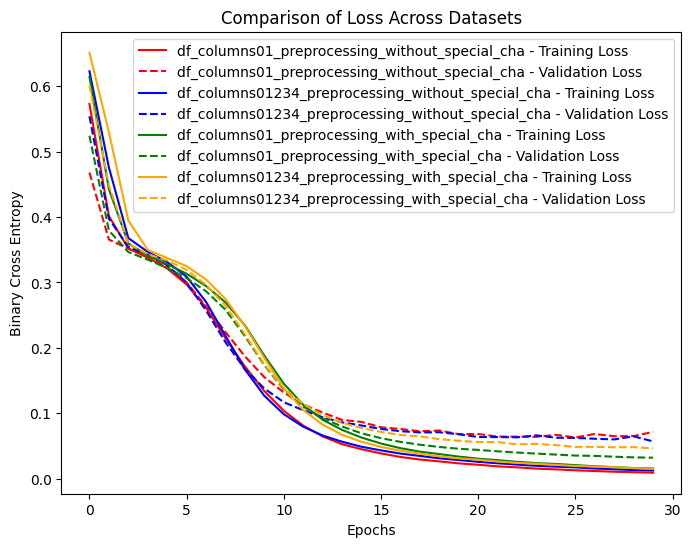

In [16]:
# Visualization of the training process on the loss function

plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]
for i, (loss, val_loss, df_name) in enumerate(zip(loss_values, val_loss_values, df_preprocessed_list.keys())):
    color = colors[i % len(colors)] # i divided by number of colors, to know where we are
    plt.plot(loss, color=color, linestyle='-', label=f"{df_name} - Training Loss")
    plt.plot(val_loss, color=color, linestyle='--', label=f"{df_name} - Validation Loss")
plt.ylabel("Binary Cross Entropy")
plt.xlabel("Epochs")
plt.title("Comparison of Loss Across Datasets")
plt.legend()
plt.show()


In [17]:
print("In the dataframe with removal the 3 columns and removing special characters (red), the model reaches low loss later than others.")
print("In the dataframe with keeping all columns and keeping special characters (orange), the val and train are the furthest from each other.")
print("It seems that the best dataframe is the one where we remove the 3 columns and keep special characters (green).")
print("Indeed, the val loss is the lowest, and the distance between val and train is short, and the loss decreases the fastest.")

In the dataframe with removal the 3 columns and removing special characters (red), the model reaches low loss later than others.
In the dataframe with keeping all columns and keeping special characters (orange), the val and train are the furthest from each other.
It seems that the best dataframe is the one where we remove the 3 columns and keep special characters (green).
Indeed, the val loss is the lowest, and the distance between val and train is short, and the loss decreases the fastest.


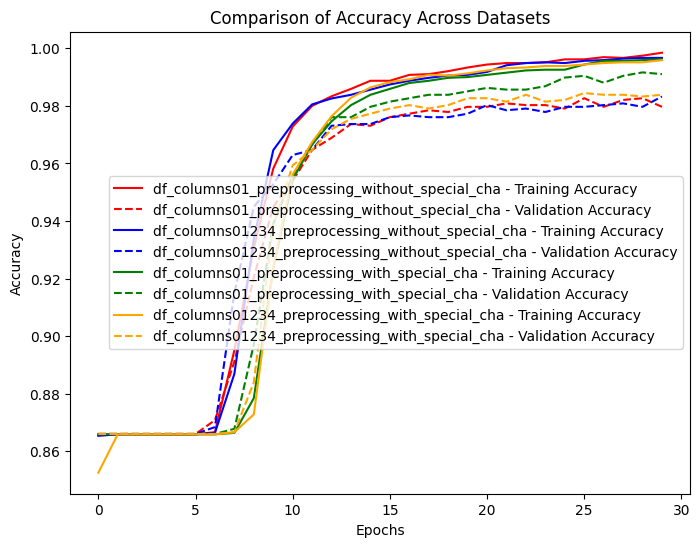

In [18]:
# Visualization of accuracy training

plt.figure(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]
for i, (accuracy, val_accuracy, df_name) in enumerate(zip(accuracy_values, val_accuracy_values, df_preprocessed_list.keys())):
    color = colors[i % len(colors)]
    plt.plot(accuracy, color=color, linestyle='-', label=f"{df_name} - Training Accuracy")
    plt.plot(val_accuracy, color=color, linestyle='--', label=f"{df_name} - Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Comparison of Accuracy Across Datasets")
plt.legend()
plt.show()

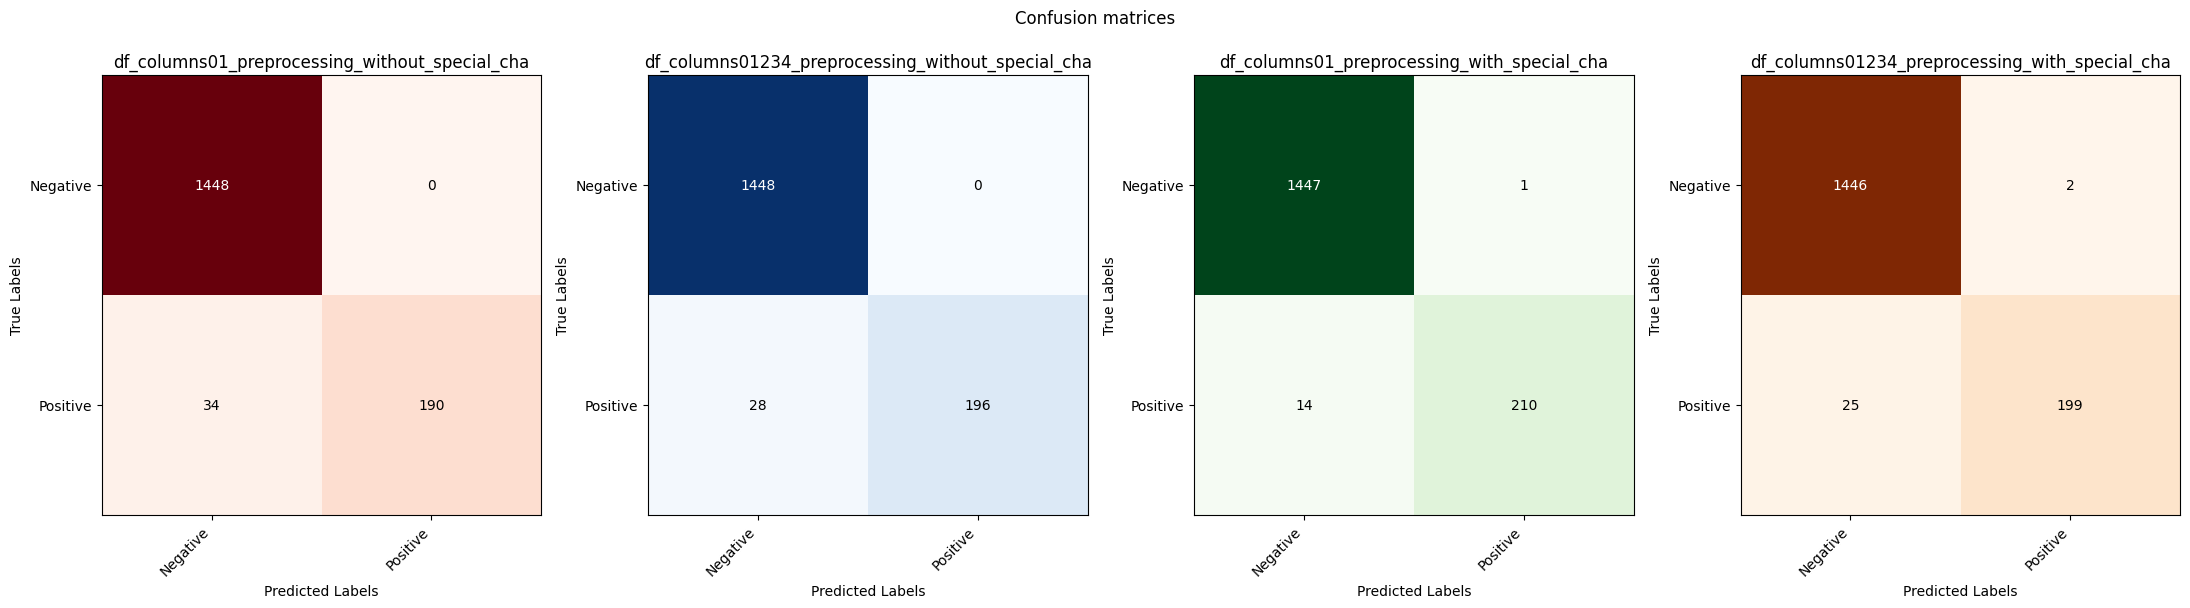

Here we also confirmed that the best preprocessing was the green one (less false positive/neg)


In [30]:
# Confusion matrix

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
colors = ["Reds", "Blues", "Greens", "Oranges"]

for i, (confusion_matrix, df_name) in enumerate(zip(confusion_matrix_lists, df_preprocessed_list.keys())):
    # Plot confusion matrix
    ax = axs[i]
    ax.imshow(confusion_matrix, cmap=colors[i % len(colors)])
    ax.set_title(f'{df_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    # Set tick labels
    classes = ['Negative', 'Positive']
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Rotate tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Loop over data dimensions and create text annotations
    for i in range(len(classes)):
        for j in range(len(classes)):
            text_color = "white" if (i == 0 and j == 0) else "black"  # Set text color to white for true negatives (too dark background)
            text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color=text_color)
plt.suptitle("Confusion matrices")
plt.tight_layout()
plt.show()

print("Here we also confirmed that the best preprocessing was the green one (less false positive/neg)")

In [31]:
print("Our model is already quite good like this. The best preprocessing seems to be with removal of columns 2,3,4 and no removal of special characters.")
print("In general, most negative and positives are predicted correctly but we could still improve the model to remove the false negative and false positive.")

Our model is already quite good like this. The best preprocessing seems to be with removal of columns 2,3,4 and no removal of special characters.
In general, most negative and positives are predicted correctly but we could still improve the model to remove the false negative and false positive.
